In this notebook, I use GB: UNHCR + GTrends to predict outflows. Then i use this model to inform ensembled dyad models, where the data includes: dyad-specific unhcr data + countries and cities google trends data (but not all of it).
I get a relative RMSE of .67.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor #, AdaBoostRegressor
#from xgboost import XGBRegressor

In [2]:
path = '../../data/clean/'
SEED = 12

## Step 0: Naive model (RW)

First, let's load our main dataset with UNCHR covariates and consider the list of countries to make outflow predictions on.

In [3]:
data_outflows = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)
data_outflows = data_outflows.reset_index()
data_outflows["year"] = data_outflows["year"].dt.year

In [4]:
# Rename target column
data_outflows = data_outflows.rename(columns={'newarrival': 'ref_outflow'})

data_outflows.shape


(4900, 19)

In [5]:
# Store the list of countries to predict

iso_3 = data_outflows.iso_o.unique().tolist()

len(iso_3)

196

In [6]:
# Create train/test split
test_time_start = 2018
test_time_end = 2021
train = data_outflows.loc[data_outflows.year < test_time_start]
test = data_outflows.loc[(data_outflows.year >= test_time_start) & (data_outflows.year <= test_time_end)]

In [7]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="ref_outflow", lst_countries=iso_3,
                                              country_var='iso_o'
                                              )


In [8]:
mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.ref_outflow, squared=False)
print("Mse Naive RW: " + str(mse_naive))

Mse Naive RW: 107348.60953631742


In [9]:
data = {
    'iso_o': test.iso_o,
    'year': test.year,
    'y_test': test.ref_outflow,
    'y_naive': y_naive
}
predictions = pd.DataFrame(data)
predictions

,iso_o,year,y_test,y_naive
18,ABW,2018,0.0,1.0
19,ABW,2019,1.0,0.0
20,ABW,2020,0.0,1.0
21,ABW,2021,0.0,0.0
43,AFG,2018,116209.0,126154.0
...,...,...,...,...
4871,ZMB,2021,73.0,86.0
4893,ZWE,2018,1908.0,4523.0
4894,ZWE,2019,3371.0,1908.0
4895,ZWE,2020,1196.0,3371.0


## Step 1: Baseline RF using UNCHR covariates and lags for selected features

In [10]:
data_outflows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iso_o             4900 non-null   object 
 1   year              4900 non-null   int32  
 2   pop_o             4900 non-null   float64
 3   CPI_o             4900 non-null   float64
 4   GDP_PP_o          4900 non-null   float64
 5   GDP_PPP_o         4900 non-null   float64
 6   island_o          4900 non-null   int64  
 7   area_o            4900 non-null   float64
 8   landlocked_o      4900 non-null   int64  
 9   PR_o              4900 non-null   int64  
 10  CL_o              4900 non-null   int64  
 11  typeOfViolence_o  4900 non-null   int64  
 12  best_est_o        4900 non-null   float64
 13  Nyear_conflict_o  4900 non-null   float64
 14  Nyear_log_o       4900 non-null   float64
 15  dead_log_o        4900 non-null   float64
 16  Nyear_conf_o      4900 non-null   int64  


In [11]:
data_outflows.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow'],
      dtype='object')

In [12]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_2 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]

Generating all this lags will cause us to have a bunch of nan values, which we want to avoid to be able to run RF.

I'll impute the first available value to the lag series that are missing with the helper function available in model_helpers.

In [13]:
shifted_df_filled_2 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_2, range(1, 3), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_2.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

In [14]:
data_outflows_lags.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow', 'Shift_1_CPI_o',
       'Shift_1_GDP_PP_o', 'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o'],
      dtype='object')

Apart from lags, we might want to add rolling sums for:
- best estimate for casualties from conflict
- refugee outflows

In [15]:
window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

panel_data

,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,PR_o,...,Shift_3_ref_outflow,Shift_3_dead_o,Shift_3_best_est_o,Shift_3_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
0,ABW,2000,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,2001,0.091,2.518,37813.88,0.006,1,193.0,0,5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,2002,0.092,4.162,37198.23,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,2003,0.093,2.287,37185.65,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,2004,0.095,2.774,39054.94,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,ZWE,2020,15.189,348.586,2048.27,0.025,0,390759.0,1,6,...,4523.0,0.0,0.0,0.000000,10998.0,39054.0,301203.0,14.0,14.0,16.0
4896,ZWE,2021,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,1908.0,0.0,4.0,1.386294,7115.0,21073.0,152453.0,16.0,16.0,18.0
4897,ZWE,2022,15.817,547.255,2171.10,0.025,0,390759.0,1,6,...,3371.0,0.0,8.0,2.079442,5207.0,11638.0,99862.0,14.0,18.0,19.0
4898,ZWE,2023,16.164,100.000,2184.84,0.025,0,390759.0,1,6,...,1196.0,0.0,2.0,0.693147,1836.0,7115.0,78325.0,8.0,20.0,20.0


We generate data for continents

In [16]:
continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

Finally, we drop the columns that we wouldn't know the value for the same year we are forecasting. That is, we keep only shifted variables and rolling sums, and some descriptive variables (e.g. is island, etc.)

In [17]:
unhcr = unhcr.drop(columns=['CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o'])

Binary encoding and scaling

In [18]:
unhcr.columns

Index(['iso_o_continent', 'iso_o', 'year', 'pop_o', 'island_o', 'area_o',
       'landlocked_o', 'ref_outflow', 'Shift_1_CPI_o', 'Shift_1_GDP_PP_o',
       'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o',
       'rolling_sum_past_3_ref_outflow', 'rolling_sum_past_5_ref_outflow',
       'rolling_sum_past_10_ref_outflow', 'rolling_sum_past_3_best_est_o',
       'rolling_sum_past_5_

## Step 2: Adding Google Trends data

#### Version 1:
+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ unweighted trends

In [19]:
english_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_EN.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
ol_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_orig_lang.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])
ol_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_OL.csv").drop_duplicates()

topics = pd.read_csv("../trends/data/semantic_topic_trends_2005.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
# topics.info() - nulls in country, dropping those
topics = topics[topics.country.isnull()==False]
print(topics.shape)

print(english_from_topics.shape)
# english_boss.info() # A bunch of missing dates - idk what happened there!
# We can't do much without dates so I'm dropping them - will have to check if it's worth re-downloading this 
english_boss = english_boss[english_boss.date.isnull()==False].drop(columns=["index"])
print(english_boss.shape)


# I downloaded data for a maximum of two origin languages. This might not be the best approach, but for now, I'm averaging the values when I have more than one OL.
ol_from_topics_av = ol_from_topics.groupby(['country', 'date']).mean().reset_index()
ol_boss_av = ol_boss.groupby(['country', 'date']).mean().reset_index()
# Print the transformed dataset
print(ol_from_topics_av.shape)
print(ol_boss_av.shape)

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_88119/31775143.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])


(42098, 8)
(21816, 22)
(12096, 41)
(30240, 22)
(27216, 41)


Big merge:

In [20]:
# Let's merge first keywords - english and OL - separately

english = pd.merge(english_from_topics, english_boss, on=["date", "country"], how="outer")
ol = pd.merge(ol_from_topics_av, ol_boss_av, on=["date", "country"], how="outer")
print(english.shape)
print(ol.shape)

# Get the keywords listed 
keywords = english.columns[~english.columns.isin(['country', 'date'])]
print(keywords)
topics_list = topics.columns[~topics.columns.isin(['country', 'date'])]
print(topics_list)

(24408, 61)
(30240, 61)
Index(['passport', 'Immigration', 'Travel Visa', 'Refugee', 'Conflict', 'War',
       'Violence', 'Crisis', 'Militia', 'Genocide', 'Armed Forces', 'Civilian',
       'Currency', 'Lottery', 'Economy', 'Wage', 'Protest', 'Government',
       'Bureau de change', 'Coup d’état', 'asylum', 'citizen',
       'citizenship+citizenships', 'consulate+consulates', 'crises+crisis',
       'diaspora', 'embassy+embassies', 'emigration', 'foreigner+foreigners',
       'immigrant+immigrants', 'migrate', 'migration',
       'nationality+nationalities', 'recruitment+recruitments',
       'refugee+refugees', 'repatriation', 'Schengen', 'student visa',
       'visa free', 'visa+visas', 'work visa', 'emigrant+emigrants',
       'devaluation', 'immigrate+immigrated',
       'legalization+legalisation+legalisations+legalizations',
       'naturalization+naturalisation+naturalisations+naturalizations',
       'recession+recessions', 'smuggler+smugglers+smuggling',
       'deportation+de

In [21]:
# Create a mapping dictionary for renaming the columns
rename_dict_ol = {var: f"{var}_ol" for var in keywords}
rename_dict_en = {var: f"{var}_en" for var in keywords}
rename_dict_topics = {var: f"{var}_topic" for var in topics_list}
# Rename the columns using the mapping dictionary

english_2 = english.copy()
ol_2 = ol.copy()
topics_2 = topics.copy()

english_2.rename(columns=rename_dict_en, inplace=True)
ol_2.rename(columns=rename_dict_ol, inplace=True)
topics_2.rename(columns=rename_dict_topics, inplace=True)

In [22]:
big_merge = pd.merge(english_2, ol_2, on=["country", "date"], how="outer").merge(topics_2, on=["country", "date"], how="outer")
print(big_merge.shape)
print(big_merge.columns)

(42530, 126)
Index(['date', 'passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=126)


In [23]:
trend_cols = big_merge.columns[~big_merge.columns.isin(['country','date'])].tolist()
big_merge = pd.concat([big_merge.sort_values(by=['country','date']).groupby('country')[trend_cols].apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index().drop('level_1', axis=1), big_merge.sort_values(by=['country','date'])[['date']].reset_index(drop=True)], axis=1)

Average and max values in the year:

In [24]:
avg_trends = big_merge.copy()
avg_trends["iso_o"] = avg_trends["country"].apply(lambda x: model_helpers.convert_iso2_to_iso3(x))
avg_trends.set_index('date', inplace=True)
avg_trends.index = pd.DatetimeIndex(avg_trends.index)
avg_trends = avg_trends.drop(columns=["country"])

# Group by 'iso_o' and resample by YEAR, then mean the values

avg_trends_1 = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).mean().reset_index()
avg_trends_1['year'] = avg_trends_1['date'].dt.year
avg_trends_1 = avg_trends_1.drop(columns=["date"])

# Taking max 

max_trends = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).max().reset_index()
max_trends['year'] = max_trends['date'].dt.year
max_trends = max_trends.drop(columns=["date"])

keywords_new = avg_trends_1.columns[~avg_trends_1.columns.isin(['iso_o', 'year'])]

# Create a mapping dictionary for renaming the columns
rename_dict_avg = {var: f"{var}_avg" for var in keywords_new}
rename_dict_min = {var: f"{var}_min" for var in keywords_new}
rename_dict_max = {var: f"{var}_max" for var in keywords_new}

avg_trends_1.rename(columns=rename_dict_avg, inplace=True)
max_trends.rename(columns=rename_dict_max, inplace=True)

print(avg_trends_1.shape)
print(max_trends.shape)

(3722, 126)
(3722, 126)


Rolling sums (all vars)

In [25]:
# First: monthly aggregation - the data comes monthly automatically when downloading large periods, 
# but because we are not controlling that necessarily during download, just in case

monthly = avg_trends.groupby(['iso_o', pd.Grouper(freq='M')]).mean().reset_index()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly = monthly.drop(columns=["date"])
monthly.shape # it's actually not necessary, same shape

(42530, 127)

In [26]:
final_keywords_list = monthly.columns[~monthly.columns.isin(['year', 'month', 'iso_o'])]
print(final_keywords_list)

Index(['passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       'Genocide_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=124)


In [27]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(monthly, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,passport_en,Immigration_en,Travel Visa_en,Refugee_en,Conflict_en,War_en,Violence_en,Crisis_en,Militia_en,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,ABW,0.0,0.0,NaN,0.0,18.0,0.0,0.0,60.0,NaN,...,73.333333,73.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,62.000000,62.000000
24,ABW,0.0,27.0,NaN,42.0,0.0,43.0,0.0,0.0,NaN,...,0.000000,0.000000,0.0,0.0,25.274725,25.274725,80.701754,80.701754,0.000000,0.000000
36,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,26.666667,26.666667,0.0,0.0,24.175824,24.175824,0.000000,0.000000,10.000000,10.000000
48,ABW,0.0,0.0,NaN,0.0,0.0,8.0,0.0,0.0,NaN,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,15.789474,15.789474,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42481,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.500000,12.500000,22.0,22.0,9.090909,9.090909,8.247423,8.247423,14.084507,14.084507
42493,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.928571,8.928571,31.0,31.0,9.090909,9.090909,8.247423,8.247423,9.859155,9.859155
42505,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.142857,7.142857,12.0,12.0,0.000000,0.000000,11.340206,11.340206,11.267606,11.267606
42517,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.142857,7.142857,25.0,25.0,9.090909,9.090909,13.402062,13.402062,11.267606,11.267606


In [28]:
trends_final = pd.merge(avg_trends_1, max_trends, how='outer', on=["iso_o", "year"])
trends_final = pd.merge(trends_final, panel_trends.drop(columns=["month"]), how='outer', on=["iso_o", "year"])
trends_final

,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,17.166667,5.500000,NaN,24.333333,7.861111,9.416667,1.666667,5.250000,NaN,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,ABW,0.000000,0.000000,NaN,1.916667,10.583333,16.916667,4.083333,11.566667,NaN,...,73.333333,73.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,62.000000,62.000000
2,ABW,2.583333,5.833333,NaN,10.666667,3.416667,16.250000,0.000000,10.583333,NaN,...,0.000000,0.000000,0.0,0.0,25.274725,25.274725,80.701754,80.701754,0.000000,0.000000
3,ABW,4.333333,3.916667,NaN,5.166667,2.583333,10.666667,4.250000,7.083333,NaN,...,26.666667,26.666667,0.0,0.0,24.175824,24.175824,0.000000,0.000000,10.000000,10.000000
4,ABW,2.416667,4.333333,NaN,0.000000,2.666667,10.583333,2.250000,5.416667,NaN,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,15.789474,15.789474,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.500000,12.500000,22.0,22.0,9.090909,9.090909,8.247423,8.247423,14.084507,14.084507
3718,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.928571,8.928571,31.0,31.0,9.090909,9.090909,8.247423,8.247423,9.859155,9.859155
3719,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.142857,7.142857,12.0,12.0,0.000000,0.000000,11.340206,11.340206,11.267606,11.267606
3720,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.142857,7.142857,25.0,25.0,9.090909,9.090909,13.402062,13.402062,11.267606,11.267606


NaN imputation - replace with 0, assuming very low searches/no searches

In [29]:
trends_final = trends_final.fillna(0)

Let's try a first text-based model, without further transformations.

In [30]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow"]]
trends_final_y = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
print(trends_final.shape)
print(trends_final_y.shape) # some trends weren't picked up at all for some countries
trends_final_y = trends_final_y.fillna(0)


(3722, 622)
(3994, 623)


In [31]:
trends_final_y["target"] = trends_final_y.groupby('iso_o').ref_outflow.shift(-1)
trends_final_y = trends_final_y.drop(columns=["ref_outflow"])

#### Version 2:

+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ weighted trends - trends multiplied by population and internet penetration in the country

In [32]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

In [33]:
value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1
internet_long = internet_long.fillna(1)

internet_long = internet_long.rename(columns={"Country Code":"iso_o"})

In [34]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'year', 'pop_o', 'internet', 'ref_outflow']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
columns_to_drop = ['pop_o', 'internet']
trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged = trends_merged.fillna(0)
trends_merged.shape


(3528, 623)

IMPORTANT - I'M GENERATING THE TARGET VARIABLE ALREADY WITH FORECASTING IN MIND (SHIFTED BY 1)

In [35]:
trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
trends_merged = trends_merged.drop(columns=["ref_outflow"])

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_88119/3256047333.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)


## Step 3. Augmented model: UNHCR covariates + Google Trends

IMPORTANT NOTE ABOUT THE Y: when I first implemented the UNHCR baseline model, I lagged all of the covariates by 1 and dropped the originals.

Here, because I will be merging the UNHCR dataset to the trends dataset, and the trends dataset already has the `target` variable generated considering 1 shift, I will keep the UNHCR covariates as they are (besides considering some lags and rolling sums to add value to the prediction). 

In [36]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_1 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]

shifted_df_filled_1 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_1, range(1, 2), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_1.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

unhcr = unhcr.drop(columns=["ref_outflow"])
len(unhcr.columns)

46

In [37]:
merged_trends_cov = pd.merge(trends_merged, unhcr, on=["iso_o", "year"], how="left")

merged_trends_cov = merged_trends_cov[merged_trends_cov.year<2022]

merged_trends_cov = merged_trends_cov.dropna()
print(merged_trends_cov.shape)
merged_trends_cov.head()

(3281, 667)


,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,Shift_3_ref_outflow,Shift_3_dead_o,Shift_3_best_est_o,Shift_3_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
0,ABW,42.731267,13.690600,0.0,60.570533,19.567878,23.439967,4.148667,13.068300,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,0.0,5.313000,29.337000,46.893000,11.319000,32.062800,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,7.982500,18.025000,0.0,32.960000,10.557500,50.212500,0.000000,32.702500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,22.758667,20.570333,0.0,27.135333,13.567667,56.021333,22.321000,37.201667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,14.297000,25.636000,0.0,0.000000,15.776000,62.611000,13.311000,32.045000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')

Different models:

In [39]:
# Define the models you want to include
models = [
    #('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED)),
    #('xgb', XGBRegressor(random_state=SEED)),
    #('ada', AdaBoostRegressor(random_state=SEED)),
    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=SEED)))
]

be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()
binary_cols = ['iso_o', 'iso_o_continent','typeOfViolence_o', 'Shift_1_typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(unhcr.columns) - set(binary_cols  + ['year', 'ref_outflow']))

# Define the preprocessing steps
transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

trained_models = {}

for model_name, model in models:
    # Create the pipeline for the current model
    out_pipeline = Pipeline([
        ('preprocessing', transform_cols),
        ('model', model)
    ])

    # Fit the pipeline to your data
    out_pipeline.fit(X_train, y_train)  # Replace X and y with your input data

    # Store the fitted model in the dictionary
    trained_models[model_name] = out_pipeline

    y_pred = out_pipeline.predict(X_test)

    mse_pipe = mean_squared_error(y_test, y_pred, squared=False)

    print("RMSE outflows - " + model_name + ": " + str(mse_pipe))
    print("Relative RMSE to Naive predictions: " + str(mse_pipe/mse_naive))

RMSE outflows - gb: 57553.08342411538
Relative RMSE to Naive predictions: 0.5361325467810967


# Modeling dyad flows

## Step 1: UNHCR covariates

In [40]:
o_cols = ['Country_o', 'iso_o','Country_d', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o', 'best_est_o','Nyear_conflict_o','Nyear_log_o','dead_log_o','Nyear_conf_o', 'dead_o']
pair_cols = ['Id', 'newarrival', 'comlang_ethno', 'colony', 'comcol', 'col45', 'smctry','dist',  'index0asylum',  'contig', 'comlang_off']

unhcr_d = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop(o_cols + pair_cols, axis=1).drop_duplicates()
unhcr_dyad = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')[['iso_o','iso_d','year'] + pair_cols]

We need to include more data on destination country. We generate features for the destination country. This is the exact same method in section 1.

In [41]:
shift_cols_3 = ['dead_d', 'best_est_d', "dead_log_d"]
shift_cols_2 = [ 'CPI_d', 'GDP_PP_d', 'GDP_PPP_d',  'PR_d', 'CL_d', 'Nyear_conflict_d', 'Nyear_log_d', "typeOfViolence_d", "Nyear_conf_d"]

# Generating all this lags will cause us to have a bunch of nan values, which we want to avoid to be able to run RF.
# I'll impute the first available value to the lag series that are missing with the helper function available in model_helpers.

shifted_df_filled_2 = model_helpers.multi_shift_ffill(unhcr_d, shift_cols_2, range(1, 3), 'iso_d', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(unhcr_d, shift_cols_3, range(1, 4), 'iso_d', 'year')

unhcr_d = pd.concat([unhcr_d, shifted_df_filled_2.reset_index(drop=True).drop(columns=["year", 'iso_d'])], axis=1)
unhcr_d = pd.concat([unhcr_d, shifted_df_filled_3.reset_index(drop=True).drop(columns=["year", 'iso_d'])], axis=1)

Apart from lags, we might want to add rolling sums for:
- best estimate for casualties from conflict
- refugee outflows

In [42]:
window_sizes = [4, 6, 11]
group_cols = ['iso_d']
value_cols = ['best_est_d']

unhcr_d = model_helpers.generate_rolling_sum_variables(unhcr_d, group_cols, value_cols, window_sizes, date_col='year')

We generate data for continents

In [43]:
unhcr_d['iso_d_continent'] = unhcr_d[['iso_d']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_d':'iso_d_continent'}, axis=1)

Now let's feature engineer the dyad data.

In [44]:
import igraph as ig

df = pd.read_csv('../../data/clean/unhcr.csv', engine='pyarrow').groupby(['iso_o','iso_d']).agg({'newarrival':'sum','contig':'first','Country_o':'first'}).reset_index()
df_network = df[df.contig == 1]

graph2 = ig.Graph.TupleList(df_network[['iso_o','iso_d']].itertuples(index=False), directed=False)

# add island countries 
islands = df.drop_duplicates('Country_o').sort_values('Country_o').iso_o[~df.groupby('Country_o')['contig'].any().values].values

import gc
del df; gc.collect()

for i in islands:
    v = graph2.add_vertex()
    # Set the name or other properties of the added vertex if needed
    v['name'] = i

degrees_of_separation = pd.concat([unhcr_dyad.drop_duplicates(['iso_o','iso_d'])[['iso_o','iso_d']], unhcr_dyad.drop_duplicates(['iso_o','iso_d']).apply(lambda x: model_helpers.degrees_of_separation(graph = graph2, source_name = x.iso_o, target_name = x.iso_d), axis=1)], axis=1).rename({0:'degrees_of_separation'}, axis=1)

unhcr_dyad = unhcr_dyad.merge(degrees_of_separation, how ='left')

In [45]:
degrees_of_separation.to_csv('../trends/degrees_of_separation.csv', index=False)

In [46]:
# generate lagged features
shift_cols_3 = ['newarrival']
shifted_df_filled_3 = model_helpers.multi_shift_ffill(unhcr_dyad, shift_cols_3, range(1, 4), 'Id', 'year')

unhcr_dyad = pd.concat([unhcr_dyad, shifted_df_filled_3.reset_index(drop=True).drop(columns=["year", 'Id'])], axis=1)

# generate rolling sums
window_sizes = [4, 6, 11]
group_cols = ['Id']
value_cols = ['newarrival']

unhcr_dyad = model_helpers.generate_rolling_sum_variables(unhcr_dyad, group_cols, value_cols, window_sizes, date_col='year')

Now we merge the outflow data (merged_trends_cov), dyad data, and destination data.

In [47]:
unhcr_dyad_full = unhcr_dyad.merge(merged_trends_cov.drop('target',axis=1), on=['iso_o','year']).merge(unhcr_d, on=['iso_d','year'], how='left')

## Dyad specific google trends

#### Countries

In [48]:
countries_trends = pd.read_csv('../trends/data/2005_topics/country_topic_trends_2005_complete.csv').dropna()
countries_trends_2 = pd.read_csv('../trends/data/2005_topics/country_topic_trends_2005_order2.csv').dropna()
countries_trends_3 = pd.read_csv('../trends/data/2005_topics/country_topic_trends_2005_top_remaining.csv').dropna()

countries_trends = pd.concat([countries_trends, countries_trends_2, countries_trends_3], axis=0).rename({'value':'country_trend'}, axis=1)
country_topic_ids = pd.read_csv('../trends/topic_ids/country_topic_ids.csv')[['topic_mid','topic_title']]
countries_trends = countries_trends.merge(country_topic_ids).drop('topic_mid', axis=1)

In [49]:
import country_converter as coco

def country_to_iso3(long):
    return coco.convert(long, to='iso3')

countries_trends['iso_o'] = model_helpers.mapper(countries_trends.country_o, country_to_iso3)
countries_trends['iso_d'] = model_helpers.mapper(countries_trends.topic_title, country_to_iso3)

countries_trends.drop(['country_o','topic_title'], axis=1, inplace=True)

countries_trends = countries_trends.groupby(['iso_o','iso_d']).apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index(drop=True)

#### Cities

In [50]:
cities = pd.read_csv('../trends/data/2005_topics/cities_topic_trends_2005_order1.csv').dropna().drop_duplicates()
cities_2 = pd.read_csv('../trends/data/2005_topics/cities_topic_trends_2005_order2.csv').dropna().drop_duplicates()
cities_3 = pd.read_csv('../trends/data/2005_topics/cities_topic_trends_2005_top_remaining.csv').dropna().drop_duplicates()

cities = pd.concat([cities,cities_2,cities_3], axis=0).rename({'value':'city_trend'}, axis=1)

city_topic_ids = pd.read_csv('../trends/topic_ids/city_topic_id.csv')
cities = cities.merge(city_topic_ids, how='left', on='topic_mid').drop(['topic_mid','search_keyword','topic_type'], axis=1).dropna()
cities['city_trend'] = cities.city_trend.astype(int)

cities['iso_o'] = model_helpers.mapper(cities.country_o, country_to_iso3)
cities['iso_d'] = model_helpers.mapper(cities.search_country, country_to_iso3)

cities.drop(['country_o','search_country'], axis=1, inplace=True)

cities = cities.groupby(['iso_o','iso_d','topic_title']).apply(lambda x: x.apply(model_helpers.smooth_spikes)).reset_index(drop=True)

#### Merge and Aggregate

In [51]:
dyad_trends = cities.merge(countries_trends, on =['date','iso_d','iso_o'], how='outer')
dyad_trends = dyad_trends.groupby(['date','iso_o','iso_d'], as_index=False).agg({'city_trend':'mean','country_trend':'mean'})

dyad_trends['date'] = pd.to_datetime(dyad_trends.date)
dyad_trends['month'] = dyad_trends.date.dt.month
dyad_trends['year'] = dyad_trends.date.dt.year

def flatten_multi(df):
    df = df.copy()  # Call the copy() method to create a copy of the DataFrame
    df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]
    return df

# dyad_trends = flatten_multi(dyad_trends)  # Replace dyad_trends with your actual DataFrame variable name


In [52]:
rolling_sum_trends = model_helpers.generate_rolling_sum_variables(dyad_trends, ['iso_o','iso_d','year'], ['city_trend','country_trend'], window_sizes, date_col='month')
rolling_sum_trends = rolling_sum_trends[rolling_sum_trends["month"]==1]

In [53]:
dyad_trends.set_index('date', inplace=True)
dyad_trends = dyad_trends.groupby(['iso_o', 'iso_d', pd.Grouper(freq='Y')]).agg({'city_trend':{'mean','max'}, 'country_trend':{'mean','max'}})
dyad_trends.columns = ['_'.join(col).strip() for col in dyad_trends.columns.values]

In [54]:
dyad_trends = dyad_trends.reset_index()
dyad_trends['year'] = dyad_trends.date.dt.year

In [55]:
dyad_trends = dyad_trends.merge(rolling_sum_trends, on=['iso_o','iso_d','year']).drop(['month','date_x','date_y'], axis=1)

# NaN imputation - replace with 0, assuming very low searches/no searches. Should I do this before aggregation?
dyad_trends.fillna(0, inplace=True)

#### Weight by population and internet

In [56]:
dyad_trends = dyad_trends.merge(merged_trends_cov[['iso_o','pop_o','year']], on=["iso_o", "year"], how="left").merge( internet_long, on=["iso_o", "year"])

# Create a list of variables to weight
variables_to_multiply = [col for col in dyad_trends.columns if col not in ['iso_o','iso_d', 'year', 'pop_o', 'internet']]

# Multiply the variables by 'pop_o' and 'internet'
dyad_trends[variables_to_multiply] = dyad_trends[variables_to_multiply].multiply(dyad_trends['pop_o'], axis=0).multiply(dyad_trends['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
columns_to_drop = ['pop_o', 'internet']
dyad_trends.drop(columns=columns_to_drop, inplace=True)

In [57]:
unhcr_dyad_full = unhcr_dyad_full.merge(dyad_trends, how='left')
trend_cols = dyad_trends.columns[~dyad_trends.columns.isin(['iso_o','iso_d','year'])]
unhcr_dyad_full.loc[:, trend_cols] = unhcr_dyad_full.loc[:, trend_cols].fillna(unhcr_dyad_full[trend_cols].mean())

In [58]:
refugee_outflow_pred = pd.concat([pd.concat([X_train[['iso_o','year']].reset_index(drop=True), pd.Series(out_pipeline.predict(X_train), name='refugee_outflow_pred')], axis=1),
    pd.concat([X_test[['iso_o','year']].reset_index(drop=True), pd.Series(out_pipeline.predict(X_test), name='refugee_outflow_pred')], axis=1)], axis=0)

unhcr_dyad_full = unhcr_dyad_full.merge(refugee_outflow_pred, how='left')


### I shift newarrival, creating a variable that is next year's new arrivals. this will be the target variable to predict. ###
unhcr_dyad_full['newarrival_next_year'] = unhcr_dyad_full.groupby('Id').newarrival.shift(-1)

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_88119/91351924.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unhcr_dyad_full['newarrival_next_year'] = unhcr_dyad_full.groupby('Id').newarrival.shift(-1)


# Dyad Prediction

In [59]:
# columns_to_fill = ['city_trend_mean', 'city_trend_max',
#                    'country_trend_mean', 'country_trend_max',
#                    'rolling_sum_past_3_city_trend', 'rolling_sum_past_5_city_trend',
#                    'rolling_sum_past_10_city_trend', 'rolling_sum_past_3_country_trend',
#                    'rolling_sum_past_5_country_trend',
#                    'rolling_sum_past_10_country_trend']

# unhcr_dyad_trends = unhcr_dyad.merge(refugee_outflow_pred).dropna().merge(dyad_trends, how='left')
# unhcr_dyad_trends[columns_to_fill] = unhcr_dyad_trends[columns_to_fill].fillna(unhcr_dyad_trends[columns_to_fill].mean())

In [60]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr_dyad_full.dropna(), 'newarrival_next_year', test_time_start, test_time_end, 'year')

In [61]:
mse_naive_dyad = mean_squared_error(y_test, unhcr_dyad_full.loc[y_test.index, 'newarrival'], squared = False)

In [62]:
from sklearn.decomposition import PCA

# Define the models you want to include
models = [
    #('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED)),
    #('xgb', XGBRegressor(random_state=SEED)),
    #('ada', AdaBoostRegressor(random_state=SEED)),
    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=SEED)))
]

be = BinaryEncoder() # doing be on everything yields better results
cont_transformer = ColumnTransformer(
    [
        ('scaler', RobustScaler())# ,
        #('pca', PCA(n_components = .95))
    ])
binary_cols = ['iso_o', 'iso_d','Id', 'iso_o_continent','iso_d_continent']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(X_train.columns) - set(binary_cols  + ['year']))

# Define the preprocessing steps
transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

trained_models = {}

for model_name, model in models:
    # Create the pipeline for the current model
    pipeline = Pipeline([
        ('preprocessing', transform_cols),
        ('model', model)
    ])

    # Fit the pipeline to your data
    pipeline.fit(X_train, y_train)  # Replace X and y with your input data

    # Store the fitted model in the dictionary
    trained_models[model_name] = pipeline

    y_pred = pipeline.predict(X_test)

    mse_pipe = mean_squared_error(y_test, y_pred, squared=False)

    print("RMSE outflows - " + model_name + ": " + str(mse_pipe))
    print("Relative RMSE to Naive predictions: " + str(mse_pipe/mse_naive_dyad))

RMSE outflows - gb: 2221.292923823596
Relative RMSE to Naive predictions: 0.8383670703341843


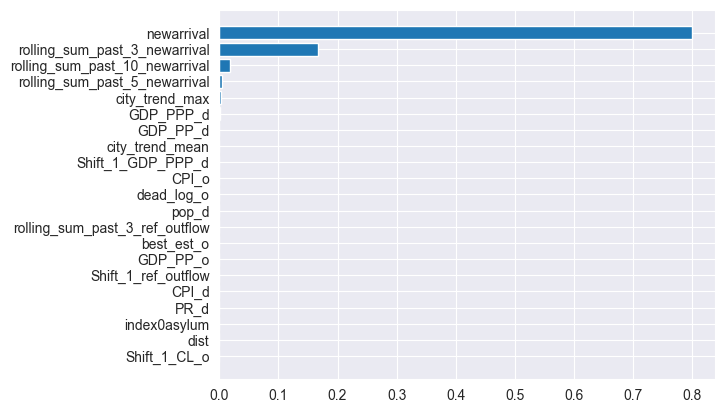

In [ ]:
# Get feature importances from random forest model
importances = pipeline.named_steps['model'].model.feature_importances_

# Get column names from ColumnTransformer object
column_names = list(pipeline.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols

# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

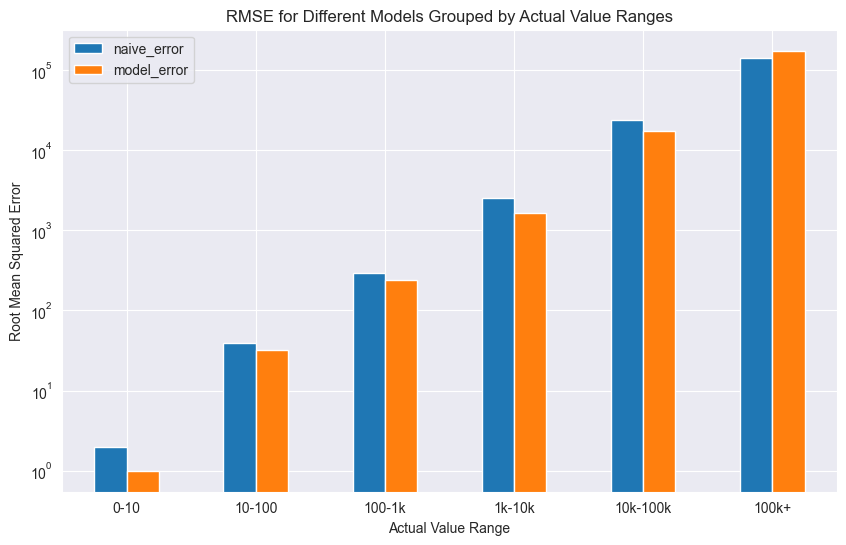

In [ ]:
predictions = pd.concat([pd.Series(y_pred, name='GB_unhcr_trends'), unhcr_dyad_full.loc[y_test.index, 'newarrival'].reset_index(drop=True), pd.Series(y_test.reset_index(drop=True), name='y_test')], axis=1)

# Compute RMSE for each row
predictions['naive_error'] = np.sqrt((predictions['y_test'] - predictions['newarrival']) ** 2)
predictions['model_error'] = np.sqrt((predictions['y_test'] - predictions['GB_unhcr_trends']) ** 2)
# results_df['RF_outflow_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
predictions['actual_range'] = pd.cut(predictions['y_test'], ranges, labels=labels, include_lowest=True)

# Compute mean RMSE for each group
grouped_errors = predictions[['naive_error', 'model_error','actual_range']].groupby('actual_range').mean()
grouped_errors

# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
plt.yscale('log')
plt.legend()
plt.show()

### Removing outflow pred
To see what difference the refugee outflow model makes, let's try dropping it and see how that affects the score.

In [65]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr_dyad_full.dropna().drop('refugee_outflow_pred', axis=1), 'newarrival_next_year', test_time_start, test_time_end, 'year')

In [66]:
from sklearn.decomposition import PCA

# Define the models you want to include
models = [
    #('rf', RandomForestRegressor(n_jobs=-1, random_state=SEED)),
    #('xgb', XGBRegressor(random_state=SEED)),
    #('ada', AdaBoostRegressor(random_state=SEED)),
    ('gb', model_helpers.LogExpModelWrapper(GradientBoostingRegressor(random_state=SEED)))
]

be = BinaryEncoder() # doing be on everything yields better results
cont_transformer = ColumnTransformer(
    [
        ('scaler', RobustScaler())# ,
        # ('pca', PCA(n_components = .9))
    ])
binary_cols = ['iso_o', 'iso_d','Id', 'iso_o_continent','iso_d_continent']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(X_train.columns) - set(binary_cols  + ['year']))

# Define the preprocessing steps
transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

trained_models = {}

for model_name, model in models:
    # Create the pipeline for the current model
    pipeline = Pipeline([
        ('preprocessing', transform_cols),
        ('model', model)
    ])

    # Fit the pipeline to your data
    pipeline.fit(X_train, y_train)  # Replace X and y with your input data

    # Store the fitted model in the dictionary
    trained_models[model_name] = pipeline

    y_pred = pipeline.predict(X_test)

    mse_pipe = mean_squared_error(y_test, y_pred, squared=False)

    print("RMSE outflows - " + model_name + ": " + str(mse_pipe))
    print("Relative RMSE to Naive predictions: " + str(mse_pipe/mse_naive_dyad))

RMSE outflows - gb: 2166.524348190488
Relative RMSE to Naive predictions: 0.817696149445071


Huh! That's weird, removing the outflow prediction actually decreased the RMSE?

### Trying different things:

In [38]:
import pandas as pd
import numpy as np
test = pd.read_csv('../../data/clean/unhcr.csv', engine='pyarrow').dropna()
test['newarrival'] = np.log(test.newarrival + 1)
test = test[['newarrival','GDP_PPP_o','CPI_o']].reset_index(drop=True)
test = test.sample(10000).reset_index(drop=True)

In [12]:
rel_matrix = test[['newarrival']]
rel_matrix['rel'] = (test.newarrival > .5).astype(int)
rel_matrix['last_col'] = 0

rel_matrix = rel_matrix.values

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_2735/2740193341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_matrix['rel'] = (test.newarrival > .5).astype(int)


In [17]:
import pandas as pd
import numpy as np
test = pd.read_csv('../../data/clean/unhcr.csv', engine='pyarrow').dropna()
test['newarrival'] = np.log(test.newarrival + 1)
test = test[['newarrival','GDP_PPP_o','CPI_o']].reset_index(drop=True)

# this doesn't work yet.
import smogn

## conduct smogn
unhcr_dyad_smogn = smogn.smoter(
    ## main arguments
    data = test,           ## pandas dataframe
    y = 'newarrival',          ## string ('header name')
    # rel_coef = .1,
    # rel_thres = 0.10, 
    # rel_xtrm_type = "high",
    # rel_method = 'auto',
    rel_ctrl_pts_rg = rel_matrix
)

/Users/ericfrey/opt/anaconda3/envs/refugees/lib/python3.11/site-packages/smogn/phi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  delta.append((y_rel[i + 1] - y_rel[i]) / h[i])


ValueError: redefine phi relevance function: all points are 0

In [59]:
test

,newarrival,GDP_PPP_o,CPI_o
0,1.609438,0.036,-3042.840501
1,0.000000,0.036,-2103.557431
2,0.000000,0.036,649.220570
3,0.000000,0.037,6.530000
4,0.000000,0.036,13.266000
...,...,...,...
955492,0.000000,0.027,3.430000
955493,1.098612,0.028,42.074000
955494,0.000000,0.025,521.150000
955495,0.693147,0.025,348.586000


In [60]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# Load the R library
smogn = importr('UBL')

# Load your dataset
test = pd.read_csv('../../data/clean/unhcr.csv', engine='pyarrow').dropna()

# Preprocess the dataset
test['newarrival'] = np.log(test['newarrival'] + 1)
test = test[['newarrival', 'GDP_PPP_o', 'CPI_o']]

# Save the pandas DataFrame to a CSV file
test.to_csv('test.csv', index=False)

# Run the R code separately
r_code = """
data <- read.csv('test.csv')

# Define custom relevance matrix
target <- data$newarrival
relevance <- ifelse(target >= 0.5, 1, 0.1)
derivative <- rep(0, length(target))
relevance_matrix <- cbind(target, relevance, derivative)

# Apply custom relevance matrix in SMOGNRegress
unhcr_dyad_smogn <- SMOGNRegress(form = newarrival ~ ., dat = data, dist = "HEOM", C.perc = list(0.2, 4), rel = relevance_matrix)
write.csv(unhcr_dyad_smogn$data, 'result_smogn.csv', row.names = FALSE)
"""
robjects.r(r_code)

# Read the result back into a pandas DataFrame
result = pd.read_csv('result_smogn.csv')

# Print the resulting Python DataFrame
print(result)


R[write to console]: Error in phi.range(y = c(`1` = 1.6094379124341, `2` = 0, `3` = 0, `4` = 0,  : 
  'x' must be *strictly* increasing (non - NA)



RRuntimeError: Error in phi.range(y = c(`1` = 1.6094379124341, `2` = 0, `3` = 0, `4` = 0,  : 
  'x' must be *strictly* increasing (non - NA)


In [21]:


## load data
housing = pd.read_csv(

    ## http://jse.amstat.org/v19n3/decock.pdf
    'https://raw.githubusercontent.com/nickkunz/smogn/master/data/housing.csv'
)

## specify phi relevance values
rg_mtrx = [

    [35000,  1, 0],  ## over-sample ("minority")
    [125000, 0, 0],  ## under-sample ("majority")
    [200000, 0, 0],  ## under-sample
    [250000, 0, 0],  ## under-sample
]

## conduct smogn
housing_smogn = smogn.smoter(
    
    ## main arguments
    data = housing,           ## pandas dataframe
    y = 'SalePrice',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.10,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)
     



r_index: 100%|##########| 126/126 [00:02<00:00, 56.37it/s]


In [28]:
test.sample(5000)

,newarrival,GDP_PPP_o,CPI_o
776247,0.0,0.054,9.000
792180,0.0,0.638,0.200
602641,0.0,0.085,0.529
164847,0.0,0.002,9.395
144132,0.0,0.005,2.261
...,...,...,...
340357,0.0,0.937,22.033
11839,0.0,0.552,5.563
630678,0.0,0.001,24.562
572612,0.0,0.087,-1.575


In [44]:


## specify phi relevance values
rg_mtrx = [
    [10, 1, 0],  ## under-sample
    [11, 1, 0],  ## under-sample
    [12, 1, 0],  ## under-sample
     [9, 1, 0],  ## under-sample
     [3, 1, 0],  ## under-sample
     [5, 1, 0],  ## under-sample
     [4, 1, 0],  ## under-sample
    [2, 1, 0],  ## under-sample
    [0, 0, 0],  ## under-sample ("majority")
    [.25, 0, 0],  ## under-sample ("majority")
    [.5, 0, 0],  ## under-sample ("majority")
    
]

## conduct smogn
unhcr_dyad_smogn = smogn.smoter(
    
    ## main arguments
    data = test,           ## pandas dataframe
    y = 'newarrival',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.10,         ## real number (0 < R < 1)
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

dist_matrix:   0%|          | 0/917 [00:00<?, ?it/s]

r_index: 100%|##########| 414/414 [00:00<00:00, 1344.86it/s]


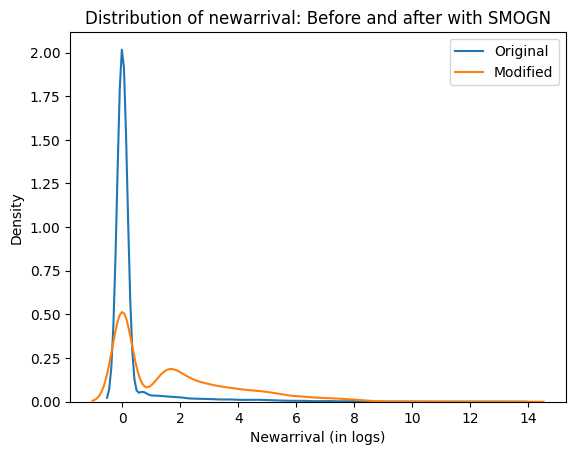

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(test['newarrival'], label="Original")
sns.kdeplot(unhcr_dyad_smogn['newarrival'], label="Modified")
# plt.yscale('log')
# plt.xscale('log')  # Setting x-axis to log scale
plt.xlabel('Newarrival (in logs)')
plt.ylabel('Density')
plt.title('Distribution of newarrival: Before and after with SMOGN')
plt.legend()
plt.show()


In [43]:
test.max()

newarrival        13.412666
GDP_PPP_o         20.012000
CPI_o         130060.240000
dtype: float64